In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
import plotly.express as px
import seaborn as sns
sns.set()
from sklearn import preprocessing
import plotly.graph_objects as go
import warnings
warnings.filterwarnings("ignore")


In [2]:
import sys,os
sys.path.insert(0, '../scripts/')
from data_preProcessing import dataProcessor
from data_exploration import dataExplorer
from data_cleaning import dataCleaner

In [3]:
nb_df = pd.read_csv("../data/nb.csv")
nb_df.head()

,Trip ID,Trip Origin,Trip Destination,Trip Start Time,Trip End Time
0,391996,"6.508813001668548,3.37740316890347","6.650969799999999,3.3450307",2021-07-01 07:28:04,2021-07-01 07:29:37
1,391997,"6.4316714,3.4555375","6.4280814653326,3.4721885847586",2021-07-01 06:38:04,2021-07-01 07:07:28
2,391998,"6.631679399999999,3.3388976","6.508324099999999,3.3590397",2021-07-01 06:21:02,2021-07-01 07:02:23
3,391999,"6.572757200000001,3.3677082","6.584881099999999,3.3614073",2021-07-01 07:16:07,2021-07-01 07:29:42
4,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36


In [4]:
dl_df = pd.read_csv("../data/driver_locations_during_request.csv")
dl_df.head()

,id,order_id,driver_id,driver_action,lat,lng,created_at,updated_at
0,1,392001,243828,accepted,6.602207,3.270465,NaN,NaN
1,2,392001,243588,rejected,6.592097,3.287445,NaN,NaN
2,3,392001,243830,rejected,6.596133,3.281784,NaN,NaN
3,4,392001,243539,rejected,6.596142,3.280526,NaN,NaN
4,5,392001,171653,rejected,6.609232,3.288800,NaN,NaN


In [5]:
dl_df.drop('id',inplace=True, axis=1)
dl_df.drop('created_at',inplace=True, axis=1)
dl_df.drop('updated_at',inplace=True, axis=1)


In [6]:
train_df = pd.merge(nb_df,dl_df,left_on='Trip ID',right_on='order_id',how='inner')
train_df.head()

,Trip ID,Trip Origin,Trip Destination,Trip Start Time,Trip End Time,order_id,driver_id,driver_action,lat,lng
0,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36,392001,243828,accepted,6.602207,3.270465
1,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36,392001,243588,rejected,6.592097,3.287445
2,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36,392001,243830,rejected,6.596133,3.281784
3,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36,392001,243539,rejected,6.596142,3.280526
4,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36,392001,171653,rejected,6.609232,3.288800


In [7]:
## objects of classes

pp = dataProcessor(train_df)
pp.show_data_information()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1557740 entries, 0 to 1557739
Data columns (total 10 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   Trip ID           1557740 non-null  int64  
 1   Trip Origin       1557740 non-null  object 
 2   Trip Destination  1557740 non-null  object 
 3   Trip Start Time   1555718 non-null  object 
 4   Trip End Time     1557740 non-null  object 
 5   order_id          1557740 non-null  int64  
 6   driver_id         1557740 non-null  int64  
 7   driver_action     1557740 non-null  object 
 8   lat               1557740 non-null  float64
 9   lng               1557740 non-null  float64
dtypes: float64(2), int64(3), object(5)
memory usage: 130.7+ MB


In [8]:
## unique column values
train_df.apply(lambda x: len(x.unique())).sort_values(ascending=False).head(20)

lat                 194406
lng                 170385
Trip ID              26492
order_id             26492
Trip End Time        25169
Trip Start Time      25155
Trip Destination     17563
Trip Origin          14578
driver_id             1213
driver_action            2
dtype: int64

# Missing values


In [9]:
pp.columns_WithMissingValue()

['Trip Start Time']

In [10]:
pp.c_missing_percentage()

,total_missing_values,missing_percentage
Trip ID,0,0.0 %
Trip Origin,0,0.0 %
Trip Destination,0,0.0 %
Trip Start Time,2022,0.13 %
Trip End Time,0,0.0 %
order_id,0,0.0 %
driver_id,0,0.0 %
driver_action,0,0.0 %
lat,0,0.0 %
lng,0,0.0 %


In [11]:
# null start time can be considered as the trip didnt take place. 
# so replace it with the end_time, so that the trip span is 0 overall.

train_df['Trip Start Time'] = train_df['Trip Start Time'].fillna(train_df['Trip End Time']) 

In [12]:
pp.columns_WithMissingValue()

[]

# result feature

In [13]:
# the result feature is weather an order is fulfilled or not. 
# fulfillment is implied by acceptance of an order + it should be ended within 30 minutes.
# i.e 'trip end time' - 'trip start time' <= 30minutes and driver_action = accepted
# we'll put 1 for fulfilled and 0 for unfullfilled in the fulfillment column

#convert to datetime
train_df['Trip Start Time'] = pd.to_datetime(train_df['Trip Start Time'], errors='coerce')
train_df['Trip End Time'] = pd.to_datetime(train_df['Trip End Time'], errors='coerce')

In [14]:

train_df['completion_minutes'] = ((train_df['Trip End Time'] - train_df['Trip Start Time']).dt.total_seconds()) / 60



In [15]:
train_df.head()

,Trip ID,Trip Origin,Trip Destination,Trip Start Time,Trip End Time,order_id,driver_id,driver_action,lat,lng,completion_minutes
0,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36,392001,243828,accepted,6.602207,3.270465,3.616667
1,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36,392001,243588,rejected,6.592097,3.287445,3.616667
2,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36,392001,243830,rejected,6.596133,3.281784,3.616667
3,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36,392001,243539,rejected,6.596142,3.280526,3.616667
4,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36,392001,171653,rejected,6.609232,3.288800,3.616667


In [16]:
def add(row):
    if row['driver_action'] == "accepted" and row['completion_minutes'] < 30:
        val = 1
    else:
        val = 0
    return val

train_df['status'] = train_df.apply(add, axis=1)
train_df.head()

,Trip ID,Trip Origin,Trip Destination,Trip Start Time,Trip End Time,order_id,driver_id,driver_action,lat,lng,completion_minutes,status
0,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36,392001,243828,accepted,6.602207,3.270465,3.616667,1
1,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36,392001,243588,rejected,6.592097,3.287445,3.616667,0
2,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36,392001,243830,rejected,6.596133,3.281784,3.616667,0
3,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36,392001,243539,rejected,6.596142,3.280526,3.616667,0
4,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36,392001,171653,rejected,6.609232,3.288800,3.616667,0


In [17]:
train_df['trip_st_date'] = pd.to_datetime(train_df['Trip Start Time']).dt.date

In [18]:
### check for holidays
#import pandas as pd
#from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

# cal = calendar()
# holidays = cal.holidays(start=train_df['Trip Start Time'].min(), end=train_df['Trip Start Time'].max())

# train_df['is_holiday'] = train_df['Trip Start Time'].isin(holidays)
# train_df.head() 

from datetime import date
from workalendar.africa import Nigeria
cal = Nigeria()

holidays = cal.holidays()
train_df['is_holiday'] = train_df['Trip Start Time'].isin(holidays)
train_df.head()


,Trip ID,Trip Origin,Trip Destination,Trip Start Time,Trip End Time,order_id,driver_id,driver_action,lat,lng,completion_minutes,status,trip_st_date,is_holiday
0,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36,392001,243828,accepted,6.602207,3.270465,3.616667,1,2021-07-01,False
1,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36,392001,243588,rejected,6.592097,3.287445,3.616667,0,2021-07-01,False
2,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36,392001,243830,rejected,6.596133,3.281784,3.616667,0,2021-07-01,False
3,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36,392001,243539,rejected,6.596142,3.280526,3.616667,0,2021-07-01,False
4,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36,392001,171653,rejected,6.609232,3.288800,3.616667,0,2021-07-01,False


In [19]:
## split trip origin to lat and lon
lat = []
long = []

## for each row in the trip origin (lat,long) pair
for row in train_df['Trip Origin']:
    # split the row by comma, and append everything before comma to lat.
    lat.append(row.split(',')[0])
    # append everything remaining to long
    long.append(row.split(',')[1])

In [20]:
# add separate columns
train_df['Tr_or_latitude'] = lat
train_df['Tr_or_longitude'] = long

In [21]:
train_df.head()

,Trip ID,Trip Origin,Trip Destination,Trip Start Time,Trip End Time,order_id,driver_id,driver_action,lat,lng,completion_minutes,status,trip_st_date,is_holiday,Tr_or_latitude,Tr_or_longitude
0,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36,392001,243828,accepted,6.602207,3.270465,3.616667,1,2021-07-01,False,6.6010417,3.2766339
1,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36,392001,243588,rejected,6.592097,3.287445,3.616667,0,2021-07-01,False,6.6010417,3.2766339
2,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36,392001,243830,rejected,6.596133,3.281784,3.616667,0,2021-07-01,False,6.6010417,3.2766339
3,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36,392001,243539,rejected,6.596142,3.280526,3.616667,0,2021-07-01,False,6.6010417,3.2766339
4,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36,392001,171653,rejected,6.609232,3.288800,3.616667,0,2021-07-01,False,6.6010417,3.2766339


In [22]:
## calculate distance between driver location and trip origin, In meters
#import h3
from geopy import distance 
train_df['Distance'] = train_df.apply(lambda row: distance.distance((row['lat'],row['lng']),
                                   (row['Tr_or_latitude'],row['Tr_or_longitude'])).km * 1000, axis=1)


In [23]:
train_df.head()

,Trip ID,Trip Origin,Trip Destination,Trip Start Time,Trip End Time,order_id,driver_id,driver_action,lat,lng,completion_minutes,status,trip_st_date,is_holiday,Tr_or_latitude,Tr_or_longitude,Distance
0,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36,392001,243828,accepted,6.602207,3.270465,3.616667,1,2021-07-01,False,6.6010417,3.2766339,694.263614
1,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36,392001,243588,rejected,6.592097,3.287445,3.616667,0,2021-07-01,False,6.6010417,3.2766339,1551.694105
2,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36,392001,243830,rejected,6.596133,3.281784,3.616667,0,2021-07-01,False,6.6010417,3.2766339,786.776508
3,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36,392001,243539,rejected,6.596142,3.280526,3.616667,0,2021-07-01,False,6.6010417,3.2766339,692.053650
4,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36,392001,171653,rejected,6.609232,3.288800,3.616667,0,2021-07-01,False,6.6010417,3.2766339,1621.848107


In [ ]:
train_df.to_csv('../data/merged.csv', index=False)

In [24]:
exp = dataExplorer()
train_df['status'].value_counts()

0    1550483
1       7257
Name: status, dtype: int64

In [25]:
exp = dataExplorer()
train_df['driver_action'].value_counts()

rejected    1531837
accepted      25903
Name: driver_action, dtype: int64

In [26]:
train_df_acc = train_df[train_df.driver_action == 'accepted']

In [27]:
train_df_acc.head()

,Trip ID,Trip Origin,Trip Destination,Trip Start Time,Trip End Time,order_id,driver_id,driver_action,lat,lng,completion_minutes,status,trip_st_date,is_holiday,Tr_or_latitude,Tr_or_longitude,Distance
0,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36,392001,243828,accepted,6.602207,3.270465,3.616667,1,2021-07-01,False,6.6010417,3.2766339,694.263614
10,392005,"6.565087699999999,3.3844415","6.499696300000001,3.3509075",2021-07-01 10:53:36,2021-07-01 11:27:51,392005,245597,accepted,6.549147,3.392184,34.250000,0,2021-07-01,False,6.565087699999999,3.3844415,1959.786119
61,392009,"6.6636484,3.3082058","6.6185421,3.301634",2021-07-01 06:39:51,2021-07-01 07:41:12,392009,245600,accepted,6.644829,3.289328,61.350000,0,2021-07-01,False,6.6636484,3.3082058,2947.683037
128,392013,"6.4308171,3.4341552","6.435460000000001,3.4846547",2021-07-01 08:44:09,2021-07-01 09:19:11,392013,243892,accepted,6.435331,3.424317,35.033333,0,2021-07-01,False,6.4308171,3.4341552,1197.389366
141,392014,"6.499156300000001,3.3585173","6.4280911,3.5157172",2021-07-01 06:43:07,2021-07-01 07:27:24,392014,243781,accepted,6.498221,3.360042,44.283333,0,2021-07-01,False,6.499156300000001,3.3585173,197.852931


* we observe almost zero correlation between driver and status of fulfillment of order.

# UNIVARIATE ANALYSIS

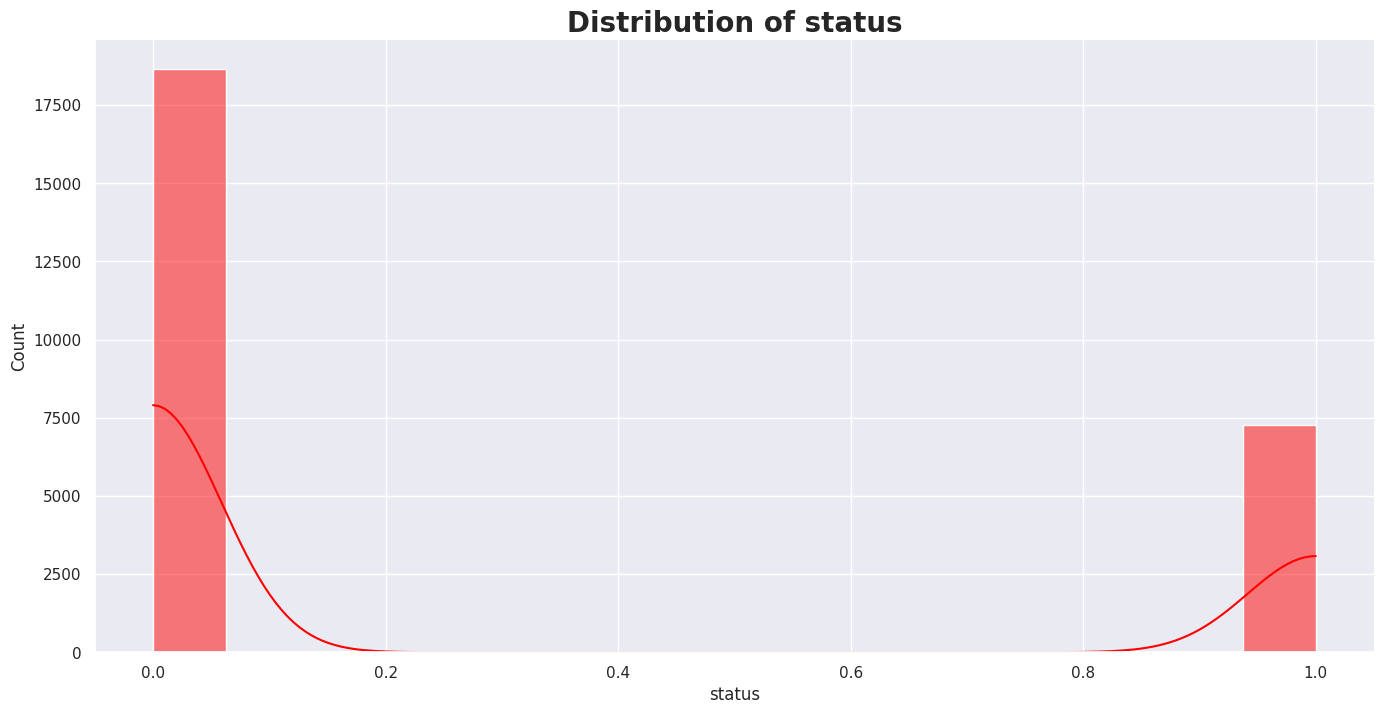

In [30]:
exp.plot_hist(train_df_acc, 'status', 'red')

* There are some thousands of fulfilled orders as seen from the value_counts and the histogram

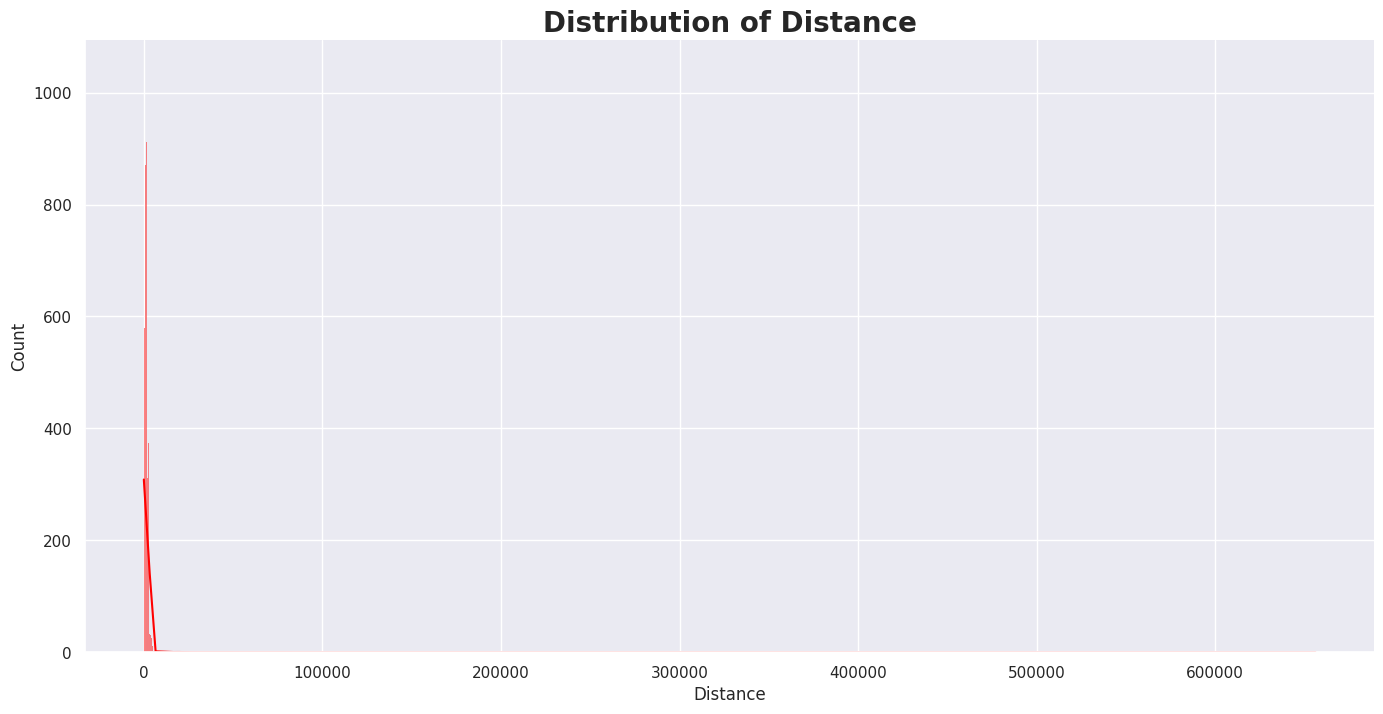

In [31]:
exp.plot_hist(train_df_acc, 'Distance', 'red')

## BIVARIATE ANALYSIS

In [32]:
train_df_acc_n = train_df_acc.copy(deep=True) 

In [33]:
train_df_acc_n["driver_action"] = np.where(train_df_acc_n["driver_action"] == "accepted",1 , 0)

In [34]:
cols = [1,2,13]
train_df_acc_bv = train_df_acc_n.drop(train_df_acc_n.columns[cols], axis=1)
train_df_acc_bv.head()

,Trip ID,Trip Start Time,Trip End Time,order_id,driver_id,driver_action,lat,lng,completion_minutes,status,trip_st_date,Tr_or_latitude,Tr_or_longitude,Distance
0,392001,2021-07-01 09:30:59,2021-07-01 09:34:36,392001,243828,1,6.602207,3.270465,3.616667,1,2021-07-01,6.6010417,3.2766339,694.263614
10,392005,2021-07-01 10:53:36,2021-07-01 11:27:51,392005,245597,1,6.549147,3.392184,34.250000,0,2021-07-01,6.565087699999999,3.3844415,1959.786119
61,392009,2021-07-01 06:39:51,2021-07-01 07:41:12,392009,245600,1,6.644829,3.289328,61.350000,0,2021-07-01,6.6636484,3.3082058,2947.683037
128,392013,2021-07-01 08:44:09,2021-07-01 09:19:11,392013,243892,1,6.435331,3.424317,35.033333,0,2021-07-01,6.4308171,3.4341552,1197.389366
141,392014,2021-07-01 06:43:07,2021-07-01 07:27:24,392014,243781,1,6.498221,3.360042,44.283333,0,2021-07-01,6.499156300000001,3.3585173,197.852931


In [35]:
# bring status column to the first index
first = train_df_acc_bv.pop('status')
train_df_acc_bv.insert(0, 'status', first)
train_df_acc_bv.head()

,status,Trip ID,Trip Start Time,Trip End Time,order_id,driver_id,driver_action,lat,lng,completion_minutes,trip_st_date,Tr_or_latitude,Tr_or_longitude,Distance
0,1,392001,2021-07-01 09:30:59,2021-07-01 09:34:36,392001,243828,1,6.602207,3.270465,3.616667,2021-07-01,6.6010417,3.2766339,694.263614
10,0,392005,2021-07-01 10:53:36,2021-07-01 11:27:51,392005,245597,1,6.549147,3.392184,34.250000,2021-07-01,6.565087699999999,3.3844415,1959.786119
61,0,392009,2021-07-01 06:39:51,2021-07-01 07:41:12,392009,245600,1,6.644829,3.289328,61.350000,2021-07-01,6.6636484,3.3082058,2947.683037
128,0,392013,2021-07-01 08:44:09,2021-07-01 09:19:11,392013,243892,1,6.435331,3.424317,35.033333,2021-07-01,6.4308171,3.4341552,1197.389366
141,0,392014,2021-07-01 06:43:07,2021-07-01 07:27:24,392014,243781,1,6.498221,3.360042,44.283333,2021-07-01,6.499156300000001,3.3585173,197.852931


In [36]:
#y is the outcome lable fulfillment, and x is non-target features
y = train_df_acc_bv.status  #1 or 0
list_drop = ['status']
X = train_df_acc_bv.drop(list_drop, axis=1)

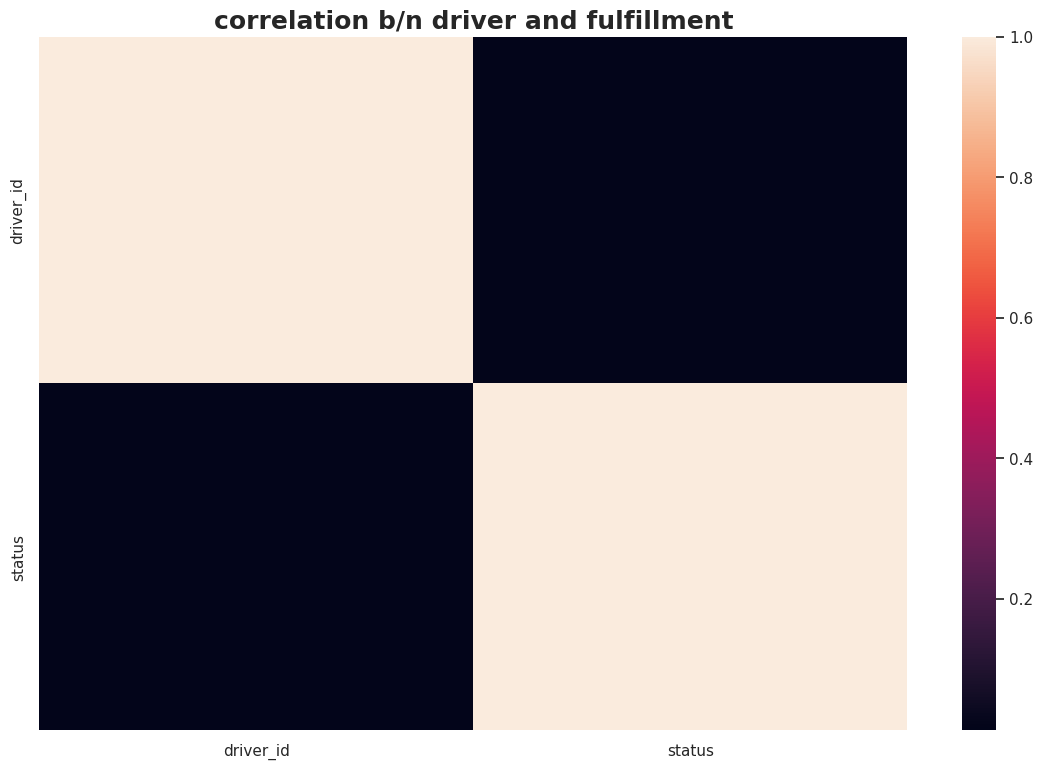

In [38]:
response_status_rln = train_df_acc.loc[:,['driver_id','status']]
corr = response_status_rln.corr()
exp.plot_heatmap_from_correlation(corr, 'correlation b/n driver and fulfillment') 


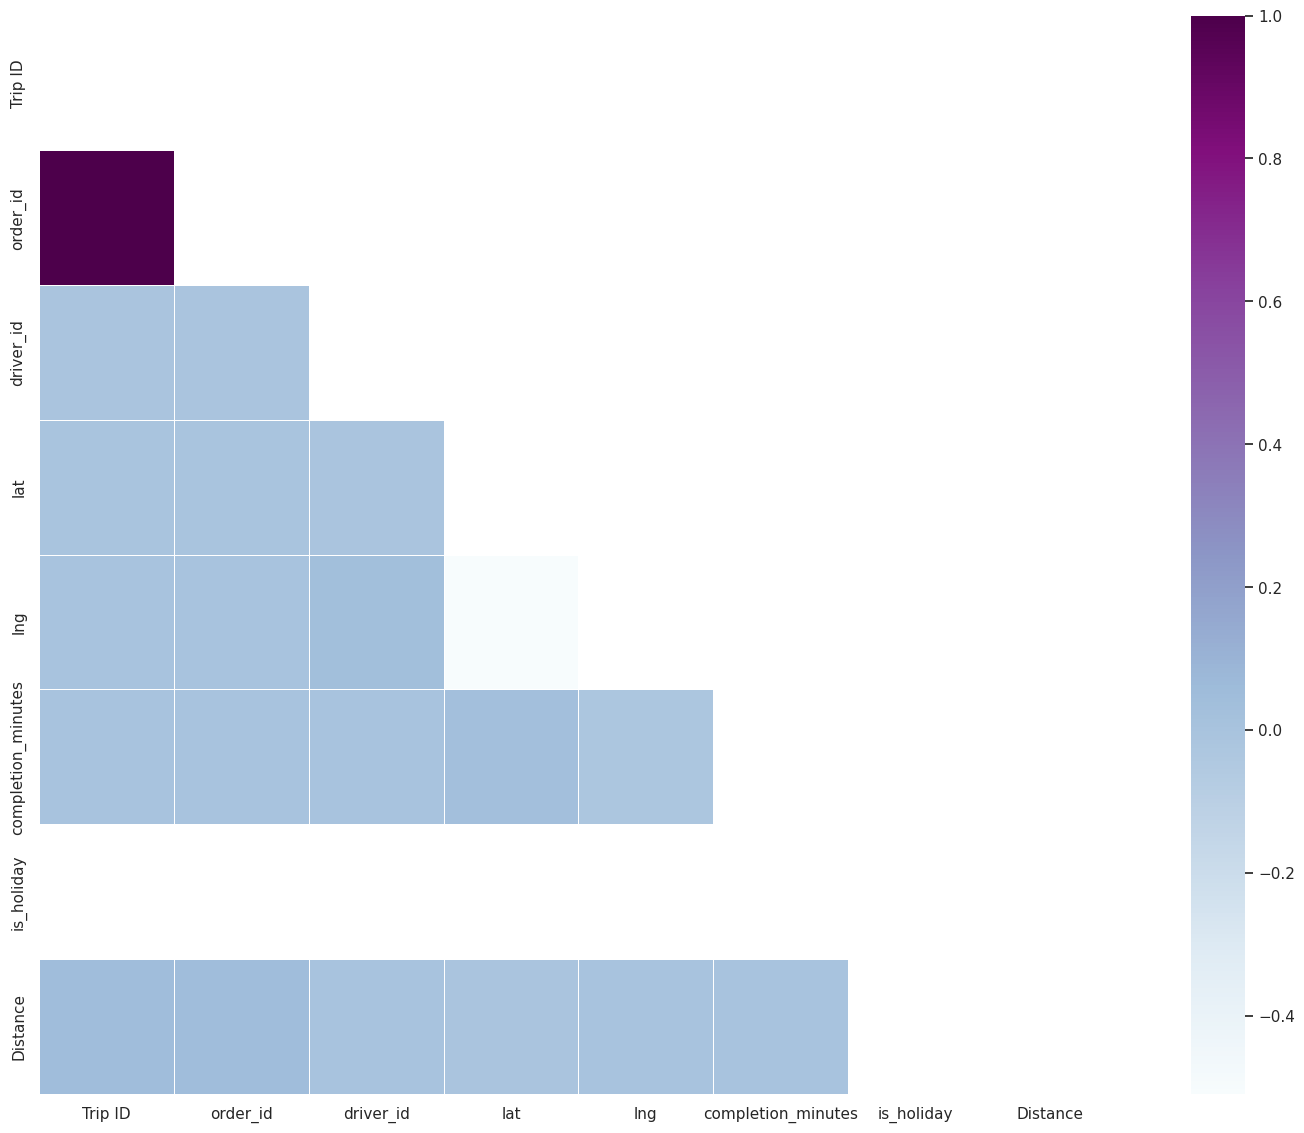

In [39]:
corr_all = train_df_acc.drop('status', axis = 1).corr()
#upper triange
mask = np.zeros_like(corr_all,dtype = np.bool)
mask[np.triu_indices_from(mask)] = True
f,ax = plt.subplots(figsize = (19,14))
sns.heatmap(corr_all, mask = mask, square = True, linewidths = 0.5, ax = ax, cmap = "BuPu")
plt.show()

In [ ]:
#Swarmplots

sns.set(style="whitegrid", palette="Set1")
data_dia = y
data = X

#data_norm = (data - data.mean()) / (data.std())
data = pd.melt(data, id_vars = 'status', var_name = "features", value_name = 'value')
plt.figure(figsize=(20,20))
sns.swarmplot(x="features",y="value",hue="status",data=data)
plt.xticks(rotation=90)

Hopalong attractor with datashader and numba

In [40]:
#Data shader
import datashader as ds
#import colorcet
from datashader import transfer_functions as tf
import numba
from numba import jit

In [41]:
width = 800
height = 800

n = 10000000

purples = plt.get_cmap('Purples')

In [42]:
@jit
def hopalong_1(x,y,a,b,c):
    return y - np.sqrt(np.fabs(b * x - c)) * np.sign(x), \
           a - x

@jit
def hopalong_2(x,y,a,b,c):
    return y - 1.0 - np.sqrt(np.fabs(b * x -1.0 - c)) * np.sign(x - 1.0), \
           a - x - 1.0

In [43]:
@jit
def trajectory(fn, a, b, c, x0=0, y0=0, n=n):
    x,y = np.zeros(n), np.zeros(n)
    x[0], y[0] = x0, y0
    for i in np.arange(n-1):
        x[i+1], y[i+1] = fn(x[i], y[i], a, b, c)
    return pd.DataFrame(dict(x=x,y=y))

In [44]:
cvs = ds.Canvas(plot_width=width, plot_height=height)

def compute_and_plot(fn,a,b,c):
    train_df_acc = trajectory(fn,a,b,c)
    agg = cvs.points(train_df_acc, 'x', 'y')
    return tf.Images(tf.shade(agg,cmap=purples))

CPU times: user 423 ms, sys: 411 ms, total: 834 ms
Wall time: 2.01 s


""

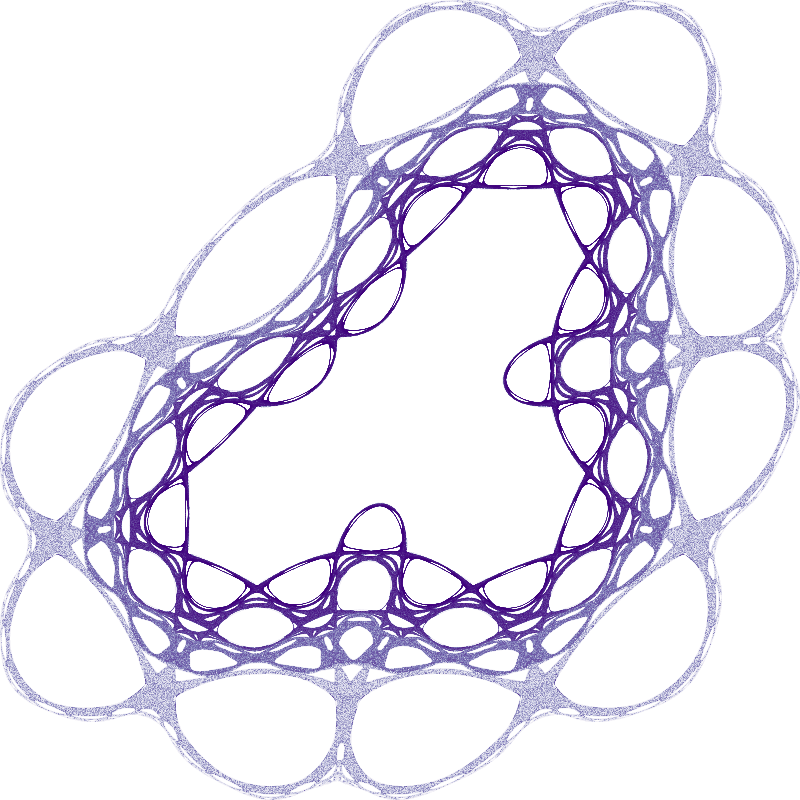

In [50]:
%%time
compute_and_plot(hopalong_1, 2.0, 1.0, 0.0)


In [51]:
plt.savefig("../data/dshader.jpg")

<Figure size 640x480 with 0 Axes>